# Vetorização de Imagens ( Image Tracing)


### 1. Banco de imagens

Começar por formas simples pra testar e depois vamos complicando,
alguns exemplos que acho que dariam certo :

In [1]:
import numpy as np
np.set_printoptions(threshold=100000)   #permite printar todo o array
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

import skimage.morphology as mm
from skimage.segmentation import watershed, join_segmentations
from skimage.segmentation import mark_boundaries

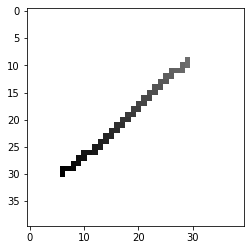

In [3]:
# Abre a imagem exemplo
triangle = Image.open('line.png').convert('L')
img = np.array(triangle)
plt.imshow(img, cmap='gray')

### 2. Detecção de bordas
Revisar os algoritmos que usamos e ver qual se adequa melhor ao nosso objetivo

*estou testando watershed*

Text(0.5, 1.0, 'Imagem segmentada - linha de watershed')

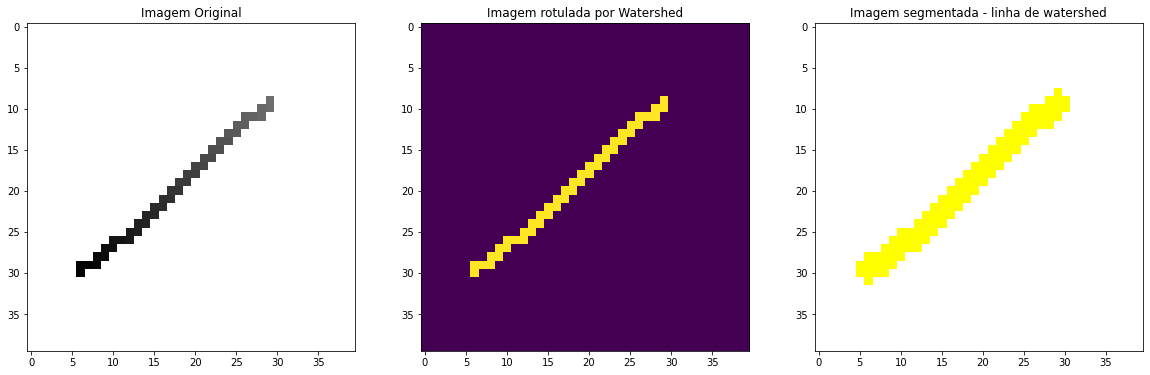

In [4]:
markers = np.zeros_like(img)
foreground, background = 1, 2 # rótulos para as sementes (objeto = 1 e fundo = 2)
markers[img < 100] = background 
markers[img > 240] = foreground

# Cálculo do watershed a partir da imagem e dos marcadores
w1 = watershed(img, markers)
plt.figure(1, figsize=(20,12))
plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title('Imagem Original')
plt.subplot(1,3,2)
plt.imshow(w1)
plt.title('Imagem rotulada por Watershed')
plt.subplot(1,3,3)
plt.imshow(mark_boundaries(img,w1))
plt.title('Imagem segmentada - linha de watershed')



*Se conseguirmos extrair as bordas (mark_boundaries) vai facilitar bastante*

In [5]:
test = mark_boundaries(img,w1)
test

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        

### 3. Algoritmo para detecção das formas básicas (retas/curvas)


* Detectar pontos de conexão (cantos) e descontinuidades nas formas


* Utilizar uma função de Fit para gerar as equações (podemos começar só com retas e equações de segundo grau) da reta/curva que interliga cada segmento 
entre 2 pontos



* Calcular o erro gerado por cada aproximação e escolher o menor
 	exemplo  P1 (35, 12)  ->    6.4x² - 2.65x + 0.12 	 ->   P2(52, 46)  
    
    
    
* Armazenar numa estrutura de dados os pontos e equações 




### 4.Plotar as formas
Pesquisar uma função de plot que plote uma equação num intervalo de 2 pontos
Iterar a função para todos os segmentos, plotando todos no mesmo gráfico
Exportar a imagem final (será que da pra fazer um pdf ou sgv?)

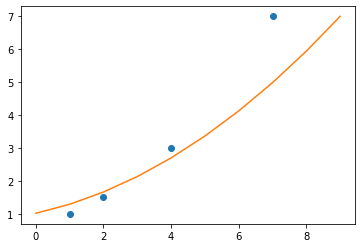

In [15]:
#### EXEMPLO DE FIT ####

points = np.array([(1, 1), (2, 1.5), (4, 3), (7, 7)])
# get x and y vectors
x = points[:,0]
y = points[:,1]

# calcula um polinomio de segunda ordem at² + bt + c e retorna as constantes a,b,c em fit
fit = np.polyfit(x, y, 2)
# cria uma malha pra amostragem do fit 
t = np.linspace(x[0], x[-1], 10)

# plota os pontos e a curva de ajuste
plt.plot(x, y, 'o')
# at² + bt + c
plt.plot(fit[0]*t*t + fit[1]*t + fit[2])


Alguns links que podem ajudar
http://www.imageprocessingplace.com/downloads_V3/root_downloads/tutorials/contour_tracing_Abeer_George_Ghuneim/moore.html
https://www.reddit.com/r/Python/comments/f2kv1/question_on_tracing_an_image_in_python_with_pil/
https://stackoverflow.com/questions/9137216/python-edge-detection-and-curvature-calculation


In [16]:
fit

array([0.10984848, 0.11742424, 0.79166667])